# Maze Roller --> Step 2

## Echtdaten einlesen

In [181]:
fileName="beideAchsen"

In [182]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sympy as sp
import scipy.linalg as linalg
sp.init_printing(use_latex='mathjax')

In [183]:
def ReadData(NameDerMessreihe, tstart=0, tend=None, info=False):
    lines = open('%s_daten.csv'%NameDerMessreihe, 'r').readlines()
    del lines[-1]
    del lines[0]
    open('%s_daten.csv'%NameDerMessreihe, 'w').writelines(lines) 
    
    src=open('%s_daten.csv'%NameDerMessreihe,"r")
    fline="time,GyroX,GyroY,GyroZ,AccX,AccY,AccZ,GyroX2,GyroY2,GyroZ2,AccX2,AccY2,AccZ2\n"    #Prepending string
    oline=src.readlines()
    oline.insert(0,fline)
    src.close()
    src=open('%s_daten.csv'%NameDerMessreihe,"w")
    src.writelines(oline)
    src.close()
    
    data = pd.read_csv('%s_daten.csv'%NameDerMessreihe)
    data.time /= 1000                        #Umwandlung in Sekunden
    data.time -= data.time[0]                #Erste Messung auf t=0s setzen
    data = data[data.time>=tstart]
    if tend is not None:
        data = data[data.time<=tend]

    
    if info:
        with open('%s_beschreibung.txt'%NameDerMessreihe, encoding='utf-8') as fd:
            print(fd.read())
            
        display(data.head(5))
#        display(data.tail(3))
    return data
#data = ReadData(fileName, info=True)

# Kalman-Filter (mit beiden Sensoren)
Unser Systemzustand x, wobei $\dot{\phi} $ die Ableitung vom Winkel darstellt:
$$     x =\left[\begin{matrix}\phi\\
       \dot{\phi}\\
       \end{matrix}\right]
$$

Unsere Messwerte y: 
$$     y =\left[\begin{matrix}gyro1.x\\gyro2.x\\
       \end{matrix}\right]
$$

## Systemtransfer-Matrix
Die Control-Input B entfällt in folgendem durch fehlendem u(t):

$$     x_{n+1} = Ad_{x_n} + Gd_{z_n} $$

$$
       \left[\begin{matrix}\phi_{n+1}\\
       \dot{\phi_{n+1}}\\
       \end{matrix}\right] = \left[\begin{matrix} 1 & Ts \\
       0 & 1 \\
       \end{matrix}\right] \cdot \left[\begin{matrix}\phi\\
       \dot{\phi}\\
       \end{matrix}\right]
$$

Für unseren Sensor gilt:
$$ \phi_{neu} = \phi_{alt} + \phi_{Gyro} \cdot Ts $$

(Veraltet: Den Offset bringen wir durch unseren Vektor C hinein. In A ist dies nicht möglich, da dann ein Fehler in der Konsistenz entsteht.)

Aus der Antwort von Edeler: Der Grund hierfür liegt darin, dass der Filter als einzige Messinformation die Änderung des Winkels durch die Gyroskope erhält nicht gleichzeitig den Absolutwert des Winkels und den Offset berechnen kann. Schließlich kann nicht unterschieden werden, ob sich der Winkel langsam ändert und daher der Gyro einen konstanten Offset liefert, oder ob es ein systematischer Fehler des Sensors ist.
 
Um das zu umgehen habe ich Ihnen eine Systembeschreibung ohne Offset angehängt.
Nun hat man natürlich keine Chance den Offset zu korrigieren. Und das macht der Filter entsprechend auch nicht. Sie sehen allerdings sehr schön, wie er erstens die Winkelgeschwindigkeit glättet und zweitens mit der Winkelschätzung (oberes Bild) genau zwischen der integrierten Winkelschwindigkeit der beiden Gyrokope liegt.
 
Sie können den Offset wieder mit ins Spiel bringen, sobald sie auch den Beschleunigungssensor mit auswerten. Dann haben Sie einen Messwert, der auch den Winkel an sich erfasst und somit ist der Offset durch den Filter berechenbar.

## Die Messmatrix C

$$ y = \dot{\phi} - \phi_{Offset}$$
$$ y = C \cdot x = \left[\begin{matrix} 0 & 1 \\ 0 & 1\\
       \end{matrix}\right] \cdot \left[\begin{matrix}\phi\\
       \dot{\phi}\\
       \end{matrix}\right] $$ 
       
## Das Prozessrauschen

$$
\dot{\mathbf x}(t) = A\mathbf x(t) + B\mathbf u(t) + G \mathbf z(t)
$$
$$
\left[\begin{matrix}\dot{\phi}\\
       \ddot{\phi}\\
       \end{matrix}\right] = \left[\begin{matrix} 0 & 1 & 0\\
       0 & 0 & 0\\
       0 & 0 & 0\\
       \end{matrix}\right] \cdot \left[\begin{matrix}\phi\\
       \dot{\phi}\\
       \end{matrix}\right] + \left[\begin{matrix}0\\
       z_1\\
       \end{matrix}\right]
$$

Im folgenden wird $G$ gebildet:
$$
 G = \left[\begin{matrix}0\\
       z_1\\
       \end{matrix}\right] =  \left[\begin{matrix}0 & 0\\
       1 & 0\\
       \end{matrix}\right] \cdot \left[\begin{matrix}z_1\\
       z_2\\
       \end{matrix}\right]
$$
Im folgenden wird $G_d$ gebildet:
$$
 G_d = \int\limits_{0}^{T_s} A_d \cdot G\, d\tau = 
 \int\limits_{0}^{T_s}\left[\begin{matrix} 1 & Ts \\
       0 & 1 \\
       \end{matrix}\right] \cdot  
 \left[\begin{matrix}0\\1\\\end{matrix}\right] 
 \, d\tau
 = \int\limits_{0}^{T_s} \begin{bmatrix}Ts\\1\\\end{bmatrix}\, d\tau
$$
$$
 G_d = \begin{bmatrix}1/2Ts^2\\Ts\\\end{bmatrix}\
$$

## System ohne explizite Berücksichtung des Offsets in den Matrizen

In [184]:
#Diese Matrizen sind mit dem Zustandsmodell x = [phi, phidot] erstellt.
#Die Messungen sind y = [gyro1, gyro2]
#Somit ist "holt" sich C jeweils das gleiche phidot aus dem Zustand.
#Gd berücksichtigt nur noch einen Rauschterm für phidot und ist daher 2x1

Ts = 33e-3

A = np.matrix([
    [0, 1],
    [0, 0],
])

Ad = np.eye(2) + Ts*A

C = np.matrix([[0, 1], 
               [0, 1]])

Gd = np.matrix([[0.5*Ts**2], 
                [Ts]])


fileName="beideAchsen"
data = ReadData(fileName, info=False)

y_phi = np.arctan2(data.AccY, data.AccZ) / np.pi * 180
y_gyro = np.array(data.GyroX)
y_gyro2 = np.array(data.GyroX2)

y = np.concatenate( (y_gyro[:,np.newaxis], y_gyro2[:,np.newaxis]), axis=1)

Q = np.diag([10])      #Prozessrauschen für die Ableitung von phidot
R = 1      #var(phix) , var(ygyro) [wird ignoriert, da in Q enthalten]

N = len(data.time)
x = list()
P = list()
K = list()

for n in range(N):
    yn = y[n:(n+1),:].T
    #yn = y[n]
    if n == 0:
        xlast = np.matrix([0,0]).T
        Plast = np.diag([1,1])*100
    else:
        xlast = x[n-1]
        Plast = P[n-1]
    
    x_priori = Ad * xlast
    P_priori = Ad * Plast * Ad.T + Gd * Q * Gd.T
    
    S = C * P_priori * C.T + R
    Kn = P_priori * C.T * linalg.pinv(S)
    x_post = x_priori + Kn*(yn - C*x_priori)
    P_post = (np.eye(2) - Kn*C)*P_priori
    
    x.append(x_post)
    P.append(P_post)
    K.append(Kn)

x = np.array(x).squeeze()
P = np.array(P).squeeze()
K = np.array(K).squeeze()

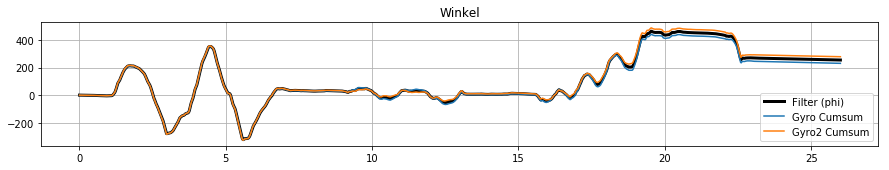

In [185]:
plt.figure(figsize=(15, 5))
ax = plt.subplot(211)
ax.set_title('Winkel')
ax.plot(data.time, x[:,0], lw=3, color = 'k', label='Filter (phi)')
ax.plot(data.time, y_gyro.cumsum()*Ts, label='Gyro Cumsum')
ax.plot(data.time, y_gyro2.cumsum()*Ts, label='Gyro2 Cumsum')
ax.grid()
ax.legend()

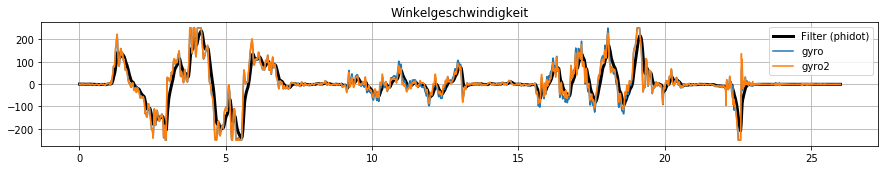

In [186]:
plt.figure(figsize=(15, 5))
ax = plt.subplot(212)
ax.set_title('Winkelgeschwindigkeit')
ax.plot(data.time, x[:,1], lw=3, color = 'k', label='Filter (phidot)')
ax.plot(data.time, y_gyro, label='gyro')
ax.plot(data.time, y_gyro2, label='gyro2')
ax.legend()
ax.grid()